# TFP Probabilistic Layers: Variational Auto Encoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

##### Copyright 2019 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");
<!-- #@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License. -->

### Dependencies & Prerequisites


In [1]:
#@title Import { display-mode: "form" }
import subprocess
import os
# Originally used to solve issue where some 
# LD_LIBRARY_PATH = os.environ['LD_LIBRARY_PATH']
# HOME = os.environ['HOME']
# os.environ["LD_LIBRARY_PATH"] = HOME+"/.conda/envs/py38/lib:"+LD_LIBRARY_PATH
# subprocess.run(["pip", "install", "tensorflow_datasets"])
# subprocess.run(["pip", "install", "tensorflow_probability"])

import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

# # TO SOLVE THE ISSUE from vae.fit, (UNIMPLEMENTED: DNN library is not found. or
# # InternalError: libdevice not found at ./libdevice.10.bc) arising from running TF and JAX concurrently
# # REFER TO: https://github.com/google/jax/issues/4920#issuecomment-1426065017
# # Reducing the allocation of memory by TF: https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # # Currently, memory growth needs to be the same across GPUs
#     # for gpu in gpus:
#     #   tf.config.experimental.set_memory_growth(gpu, True)
#     # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)
# # If the error (UNIMPLEMENTED: DNN library is not found. or InternalError: libdevice not found at ./libdevice.10.bc)
# # still persists restricting usage of GPU entirely by setting visiable devices
tf.config.experimental.set_visible_devices([], 'GPU')
# also try reducing JAX memory usage as below
# # JAX memory allocation: https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html#common-causes-of-oom-failures
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".50"

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# Verify that we have access to a GPU.
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

/home/ching.ki/.conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SUCCESS: Found GPU: /device:GPU:0


### Load Dataset

In [2]:
test_dataset = tf.data.Dataset.load("../dataset/small_labelled_ssRNA_test_dataset")
input_shape = test_dataset.element_spec.shape

def _preprocess(sample):
  ndarray = tf.cast(sample, tf.float32) / 255.  # Scale to unit interval.
  return ndarray, ndarray

test_dataset = (test_dataset
                .map(_preprocess)
                .batch(2)
                .prefetch(tf.data.AUTOTUNE)
                .shuffle(int(10e3)))

# check size of dataset
print(f'test: {test_dataset.cardinality().numpy()}')

encoded_size = 16
base_depth = 32

train: 2525
test: 2525


Note that _preprocess() above returns `image, image` rather than just `image` because Keras is set up for discriminative models with an (example, label) input format, i.e. $p_\theta(y|x)$. Since the goal of the VAE is to recover the input x from x itself (i.e. $p_\theta(x|x)$), the data pair is (example, example).

### Specify model.

In [3]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 25, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])
vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

tf.keras.utils.plot_model(vae, show_shapes=True)
tf.keras.utils.plot_model(decoder, show_shapes=True)
tf.keras.utils.plot_model(encoder, show_shapes=True)

load_status = vae.load_weights("trained_model/small_labelled_ssRNA_trained30epoch")
# load_status.assert_consumed()
# vae.predict(test_dataset.as_numpy_iterator().next()[0])
# encoder.predict(test_dataset.as_numpy_iterator().next()[0])

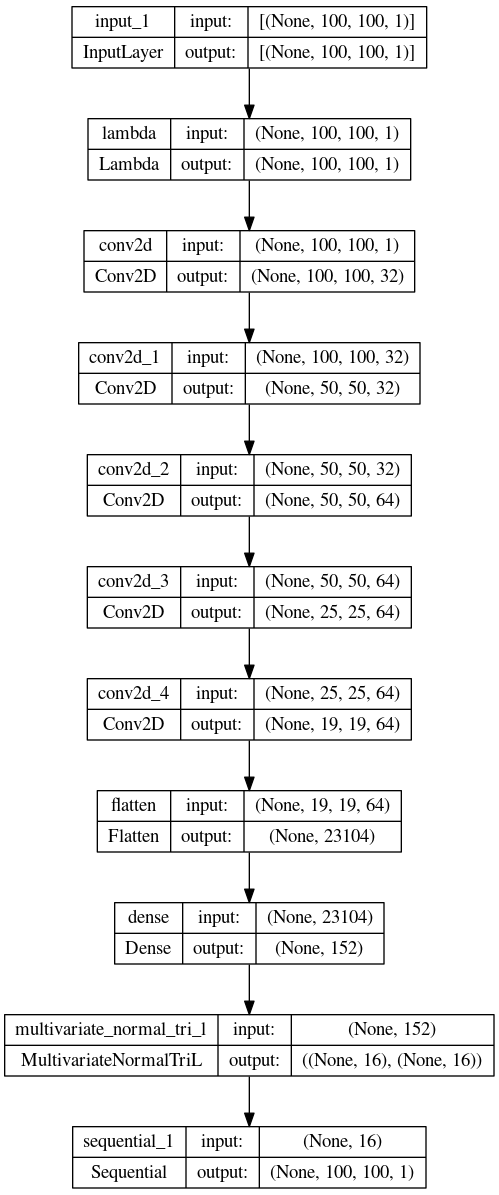

In [26]:
tf.keras.utils.plot_model(vae, show_shapes=True)

### Do inference.

#### Process input using encoder to get the latent space representation.

In [20]:
MODEL_N = [i for i in range(1, 2)]
IONS = ["Na+", "MG"]
CONCS = [c for c in range(10, 60, 10)]
spec_tuple = [(m,i,c) for m in MODEL_N for i in IONS for c in CONCS]

# loading distance arrays into dictionary
distance_arrays = dict()
for m,i,c in spec_tuple:
    distance_arrays[i+str(c)] = np.load(f"../data/distance_npz/filtered_sasdfb9_m{m}_{c}_{i}.npz")["arr_0"]

# prepocessing distance arrays so that they match the format used to train the VAE
def _preprocess_npz(sample):
  ndarray = tf.cast(sample, tf.float32) / 255.  # Scale to unit interval.
  return ndarray
preprocessed_arrays = dict()
for m,i,c in spec_tuple:
    preprocessed_arrays[i+str(c)] = _preprocess_npz(distance_arrays[i+str(c)])

# perform inferences on the processed distance arrays using the encoder to get their latent representation
latent_representation = dict()
for m,i,c in spec_tuple:
    latent_representation[i+str(c)] = encoder.predict(preprocessed_arrays[i+str(c)])
    
# store the latent representation in results folder
for m,i,c in spec_tuple:
    out_npz = f"../results/small_labelled_ssRNA_trained30epoch_latent_space/filtered_sasdfb9_m{m}_{c}_{i}.npz"
    np.savez_compressed(out_npz, latent_representation[i+str(c)])

In [4]:
vae.predict(test_dataset)

 267/2525 [==>...........................] - ETA: 1:33

KeyboardInterrupt: 